In [1]:
%matplotlib notebook
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
from pandas_profiling import ProfileReport
import numpy as np

In [2]:
url = "https://opendata.arcgis.com/datasets/2d591918912b4eb397613190ada392f3_0.geojson"
geojson = requests.get(url).json()
geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'OBJECTID': 1,
    'advisorySpeed': None,
    'animals': None,
    'areaUnitID': 538502,
    'bicycle': 0,
    'bridge': None,
    'bus': 0,
    'carStationWagon': 1,
    'cliffBank': None,
    'crashDirectionDescription': 'East',
    'crashDistance': 60,
    'crashFinancialYear': '2014',
    'crashLocation1': 'JELLICOE ST',
    'crashLocation2': 'OROUA ST',
    'crashSeverity': 'Non-Injury Crash',
    'crashSHDescription': 'No',
    'crashYear': 2014,
    'debris': None,
    'directionRoleDescription': 'West',
    'ditch': None,
    'easting': 1892604,
    'fatalCount': 0,
    'fence': None,
    'flatHill': 'Hill Road',
    'guardRail': None,
    'holiday': None,
    'houseOrBuilding': None,
    'intersectionMidblock': 'Intersection',
    'junctionType': 'Nil (Default)',
    'kerb': None,
    'light': 'Overcast',
    'meshblockId': 1214800,
    'minorInjuryCount': 0,
    'moped': 0,
    'motorcycle': 0,


In [3]:
crs = {"init": "epsg:3851"}
gdf = gpd.GeoDataFrame.from_features(geojson['features'], crs=crs)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [4]:
gdf.columns


Index(['geometry', 'OBJECTID', 'advisorySpeed', 'animals', 'areaUnitID',
       'bicycle', 'bridge', 'bus', 'carStationWagon', 'cliffBank',
       'crashDirectionDescription', 'crashDistance', 'crashFinancialYear',
       'crashLocation1', 'crashLocation2', 'crashSeverity',
       'crashSHDescription', 'crashYear', 'debris', 'directionRoleDescription',
       'ditch', 'easting', 'fatalCount', 'fence', 'flatHill', 'guardRail',
       'holiday', 'houseOrBuilding', 'intersectionMidblock', 'junctionType',
       'kerb', 'light', 'meshblockId', 'minorInjuryCount', 'moped',
       'motorcycle', 'northing', 'NumberOfLanes', 'objectThrownOrDropped',
       'otherObject', 'otherVehicleType', 'outdatedLocationDescription',
       'overBank', 'parkedVehicle', 'pedestrian', 'phoneBoxEtc', 'postOrPole',
       'region', 'roadCharacter', 'roadCurvature', 'roadLane', 'roadMarkings',
       'roadSurface', 'roadworks', 'schoolBus', 'seriousInjuryCount',
       'slipOrFlood', 'speedLimit', 'strayAnimal'

In [36]:
gdf[["road"]].head(50)

""
roadSurface
End of seal
Null
Sealed
Unsealed


<IPython.core.display.Javascript object>


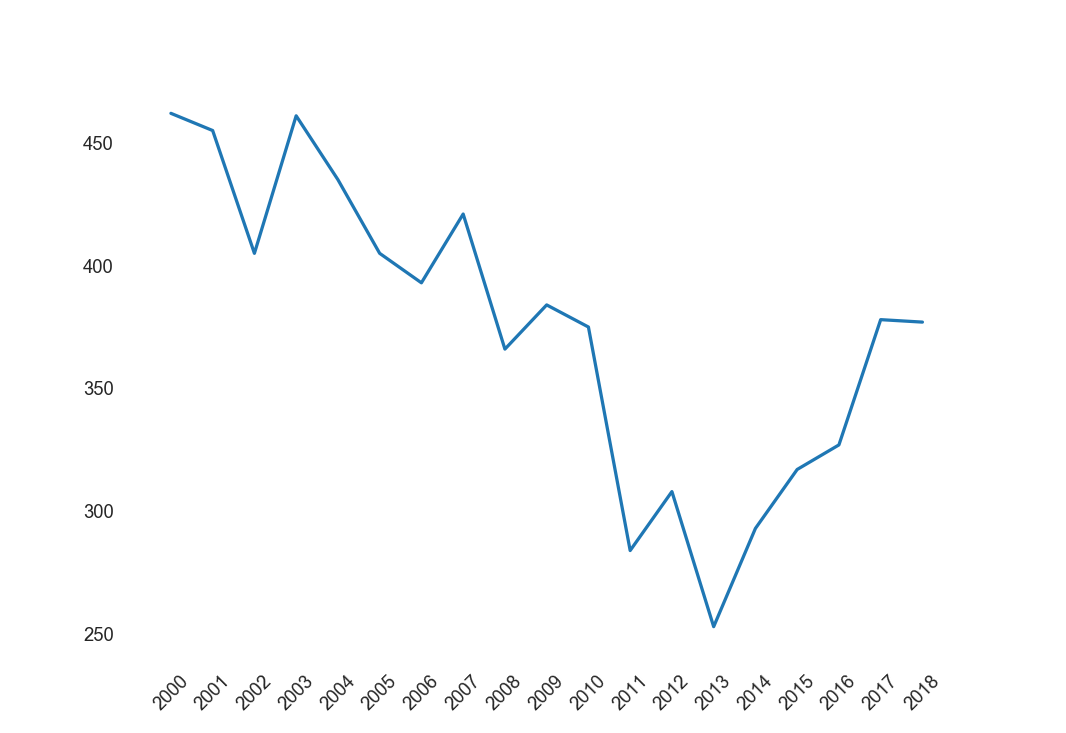

In [13]:

xy = gdf.groupby("crashYear")["fatalCount"].sum()
x = xy.index[0:-1]
y = xy.values[0:-1]
plt.xticks(np.arange(min(x), max(x) + 1, 1), rotation=45)
plt.plot(x, y)
plt.show()



<IPython.core.display.Javascript object>


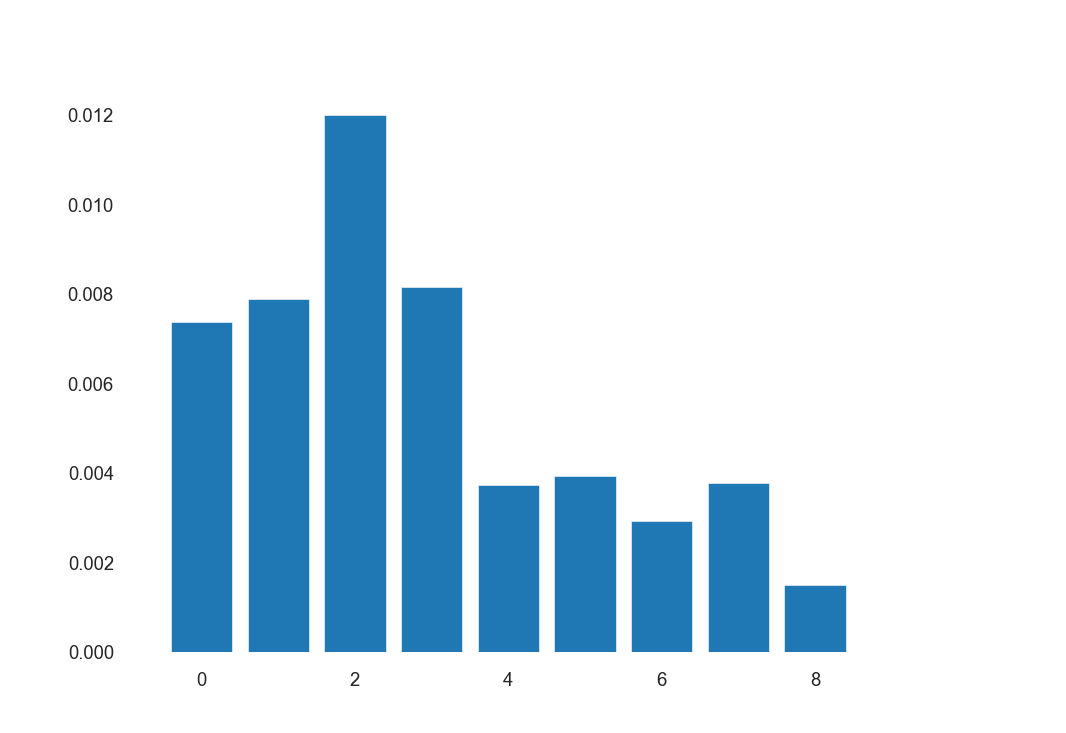

In [12]:
xy = gdf.groupby("NumberOfLanes")["fatalCount"].mean()
x = xy.index
y = xy.values
plt.bar(x, y)
plt.show()


In [92]:
from sklearn.model_selection import train_test_split
df = gdf[["weatherA", "weatherB", "speedLimit", 
          "fatalCount", "NumberOfLanes",
          "urban", "light", "crashDistance", "roadLane", "roadSurface"]].dropna()
df.speedLimit = df.speedLimit.astype(int)
df.fatalCount = df.fatalCount.astype(int)
X = pd.get_dummies(df.drop(columns="fatalCount"))

X_train, X_test, y_train, y_test = train_test_split(X, pd.DataFrame(df.fatalCount), random_state=42)

In [93]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)


In [95]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_scaled, y_train_scaled)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: 'continuous'

In [68]:
model.score(X_test_scaled, y_test)

0.9882389545737399

In [69]:
predictions = model.predict(X_test_scaled)
sum(predictions)

0.0